In [1]:
import numpy as np
from deepxde.config import set_default_float
set_default_float("float64")
# plot window size
PLOT_PARAM = {"xmin": 0, "xmax": 0.5, "ymin": -0.5,"ymax":0.5}
# contour levels
D = np.linspace(-0.225,0.0,11)

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


# Double Null

## NSTX Run Double Null Divertor

#### Solution Setup

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)
NSTX = GS_Linear(eps = 0.67/0.86,kappa = 2.0,delta = 0.35,divertor=2)
NSTX.get_BCs(A=0.0)
NSTX.solve_coefficients()

In [3]:
# make mesh
nx = 501
ny = 501
zoom = 0.25
inner_point = (1 - NSTX.eps*(1+zoom))
outer_point = (1 + NSTX.eps*(1+zoom))


high_point  = (1.1)*NSTX.kappa*NSTX.eps 
low_point   = -(1.1)*NSTX.kappa*NSTX.eps

x, y = np.meshgrid(
                np.linspace(outer_point, inner_point, nx),
    np.linspace(low_point, 
                high_point, ny),
)

X = np.vstack((np.ravel(x), np.ravel(y))).T

# Normalize and skew to set zero at boundary (Why isn't it zero already?)
psi_true = NSTX.visualize(X,np.shape(x)[0],np.shape(x)[1])



/var/folders/_4/cbmydh350ml1g91y4g56g5lw0000gn/T/ipykernel_56291/2203867720.py:5: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  v = c.collections[0].get_paths()[0].vertices


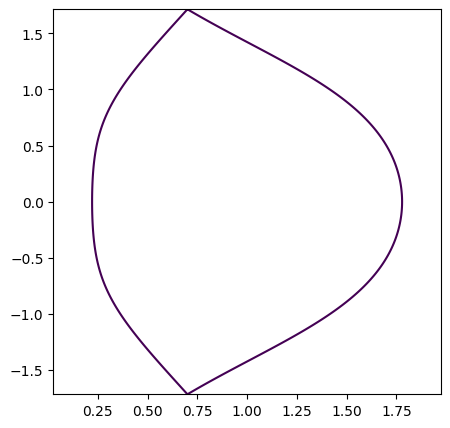

In [4]:
plt.rcParams['figure.dpi'] = 100
fig,ax=plt.subplots(1,1,figsize=(5,5))
c = ax.contour(x, y, psi_true, [0])
# ax.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])
v = c.collections[0].get_paths()[0].vertices

#### Network Setup

Text(0, 0.5, '$\\psi(r,z=0)$')

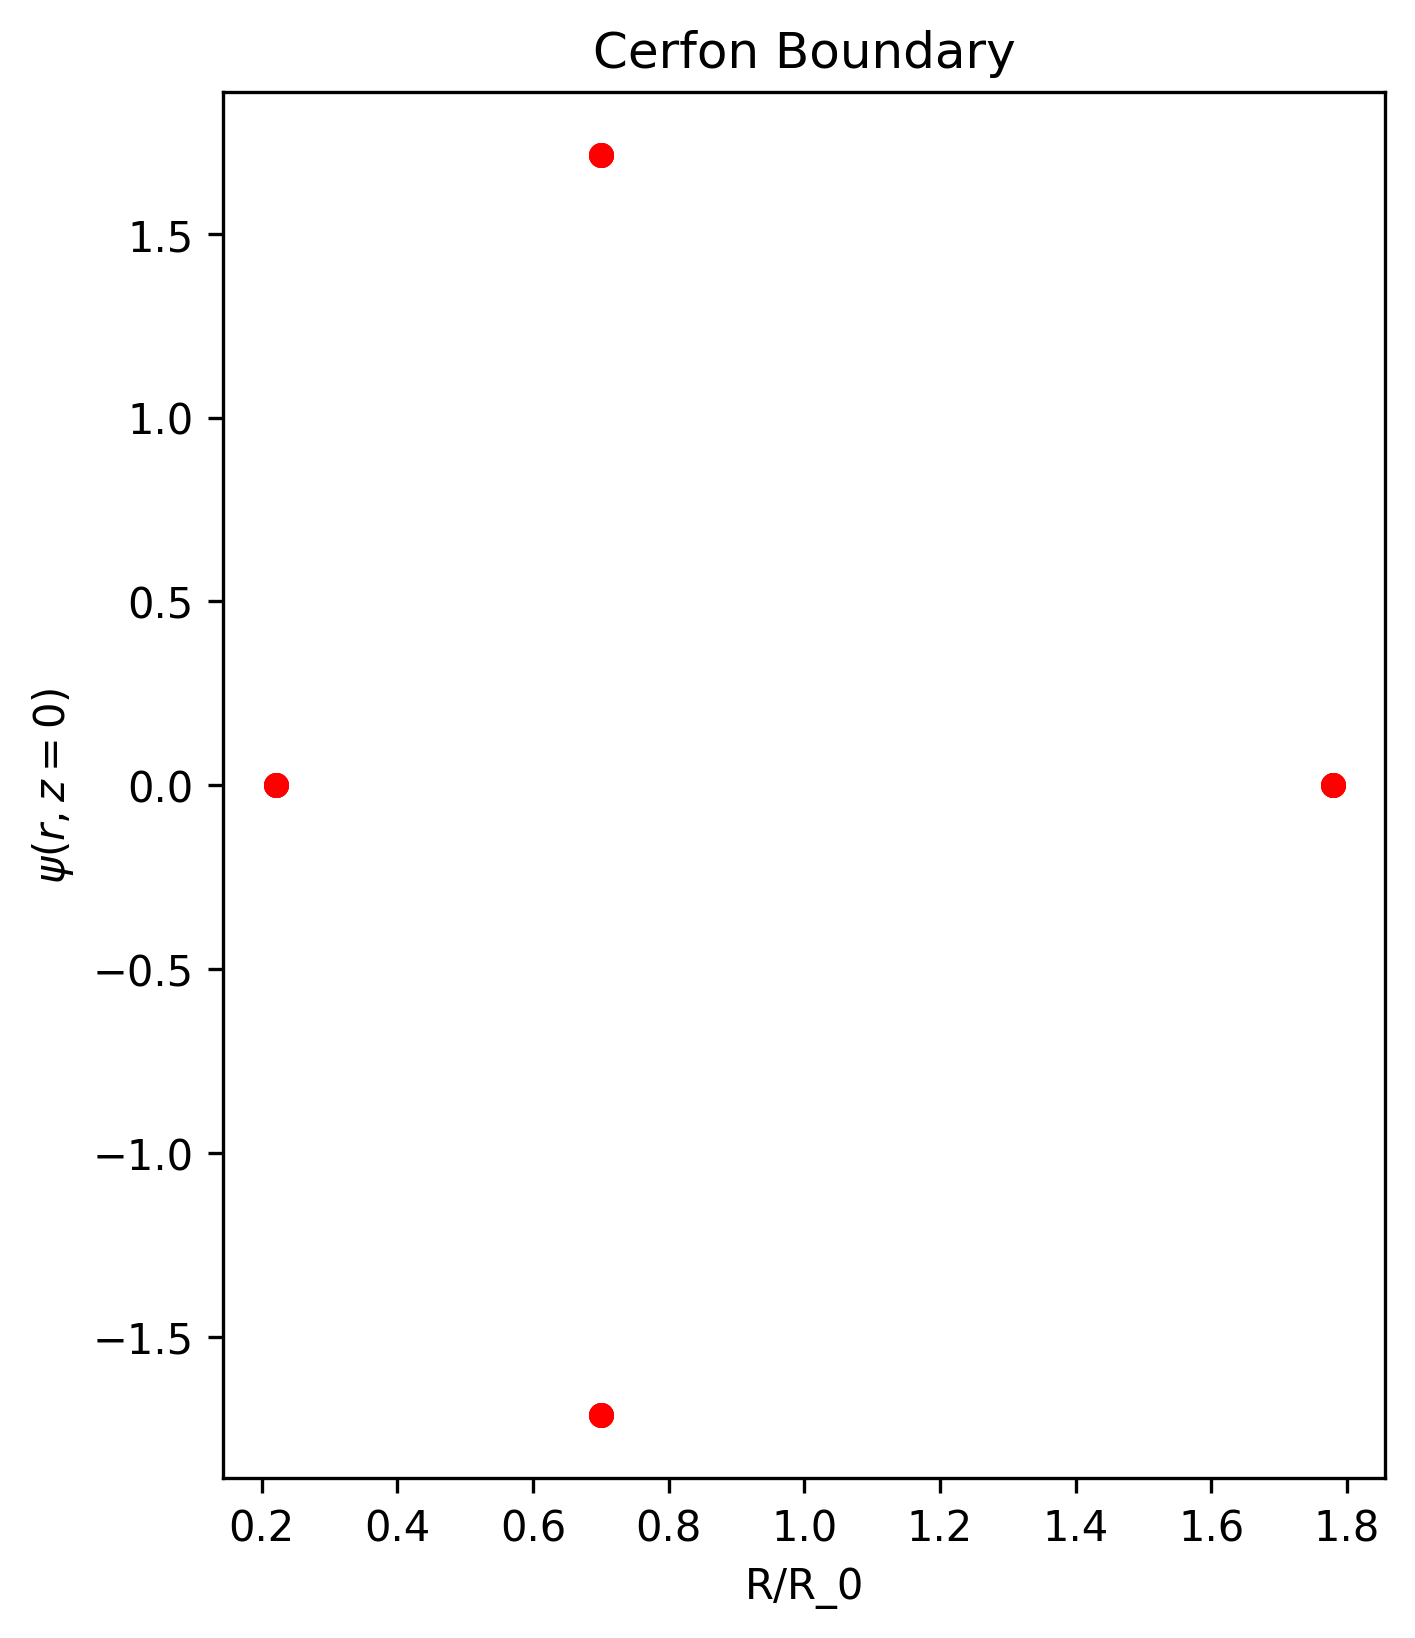

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde
plt.rcParams['figure.dpi'] = 300

A = 0.0
eps = 0.67/0.86
kappa = 2.0
delta = 0.35

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num, size):
    eps = 0.67/0.86*size
    kappa = 2.0
    delta = 0.35
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    # tau_right = np.linspace(-np.pi/16, np.pi/16, N)
    # tau_left = np.linspace(15/16*np.pi,17/16*np.pi,N)
    # tau = np.concatenate((tau_right,tau_left))
    tau = np.linspace(0,2*np.pi,N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

def boundary_outer(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 + eps, 0]).all()
def boundary_inner(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - eps, 0]).all()
def boundary_high(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, kappa * eps]).all()
def boundary_low(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - delta * eps, -kappa * eps]).all()
def boundary_high_sep(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - 1.1*delta * eps, 1.1*kappa * eps]).all()
def boundary_low_sep(x, on_boundary):
    return on_boundary and np.isclose([x[0], x[1]], [1 - 1.1*delta * eps, -1.1*kappa * eps]).all()


spatial_domain = dde.geometry.Ellipse_tokamak(eps, kappa, delta, v) 

# x,u = gen_traindata(1001,1.0)

x = v
u = np.zeros(len(x)).reshape(len(x), 1)

n_test = 101

# specify psi, psi_r, psi_z, psi_rr, psi_zz at four locations 

observe_x = np.asarray([[1 + eps, 0], 
                        [1 - eps, 0], 
                        [1 - 1.1*delta * eps, 1.1*kappa * eps],
                        [1 - 1.1* delta * eps, -1.1*kappa * eps]]
                    )
observe_y = np.asarray([0.0, 0.0, 0.0,0.0]).reshape(4, 1)

# observe_x = np.concatenate((x,observe_x))
# observe_y = np.concatenate((u,observe_y))

bc135 = dde.PointSetBC(observe_x,observe_y)
# bc135 = dde.PointSetBC(observe_x, observe_y)

# x[0] = R, x[1] = Z, u[0] = U
bc2 = dde.OperatorBC(spatial_domain ,
                    lambda x, u, _: psi_zz(x, u)+ N1*psi_r(x,u), 
                    boundary_outer)

bc4 = dde.OperatorBC(spatial_domain,
                    lambda x, u, _: psi_zz(x, u)+ N2*psi_r(x,u), 
                    boundary_inner)

# bc7 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_rr(x, u)+ N3 * psi_z(x, u), boundary_high)
bc7 =  dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_z(x, u), boundary_high_sep)
bc11 =  dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_z(x, u), boundary_low_sep)

# slope
bc6 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_r(x, u), boundary_high_sep)
bc9 = dde.OperatorBC(spatial_domain ,lambda x, u, _: psi_r(x, u), boundary_low_sep)

# Up-down symmetry
bc8 = dde.OperatorBC(spatial_domain, lambda x,u, _: psi_z(x,u), boundary_inner)
bc10 = dde.OperatorBC(spatial_domain, lambda x,u, _: psi_z(x,u), boundary_outer)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    #PDE Loss, fluxloss, outer_curv, inner_curv,high_sep_slop_r,high_sep_slop_z, inner_slop_z, low_sep_slop_r,outer_slop_z,high_sep_slop_z
    [bc135,bc2,bc4,bc6,bc7,bc8,bc9,bc10,bc11], 
    anchors=observe_x,
    num_domain=1024,
    num_boundary=0,
    num_test=n_test,
    train_distribution="LHS"
)

net = dde.maps.FNN([2] + 4 * [40] + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,6))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 25, color='r')
# ax.scatter(x_test[:,0], x_test[:,1], s = 25, color='r')
# ax.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

ax.set_title('Cerfon Boundary')
ax.set_xlabel(r'R/R_0')
ax.set_ylabel(r'$\psi(r,z=0)$')

Text(0, 0.5, '$\\psi(r,z=0)$')

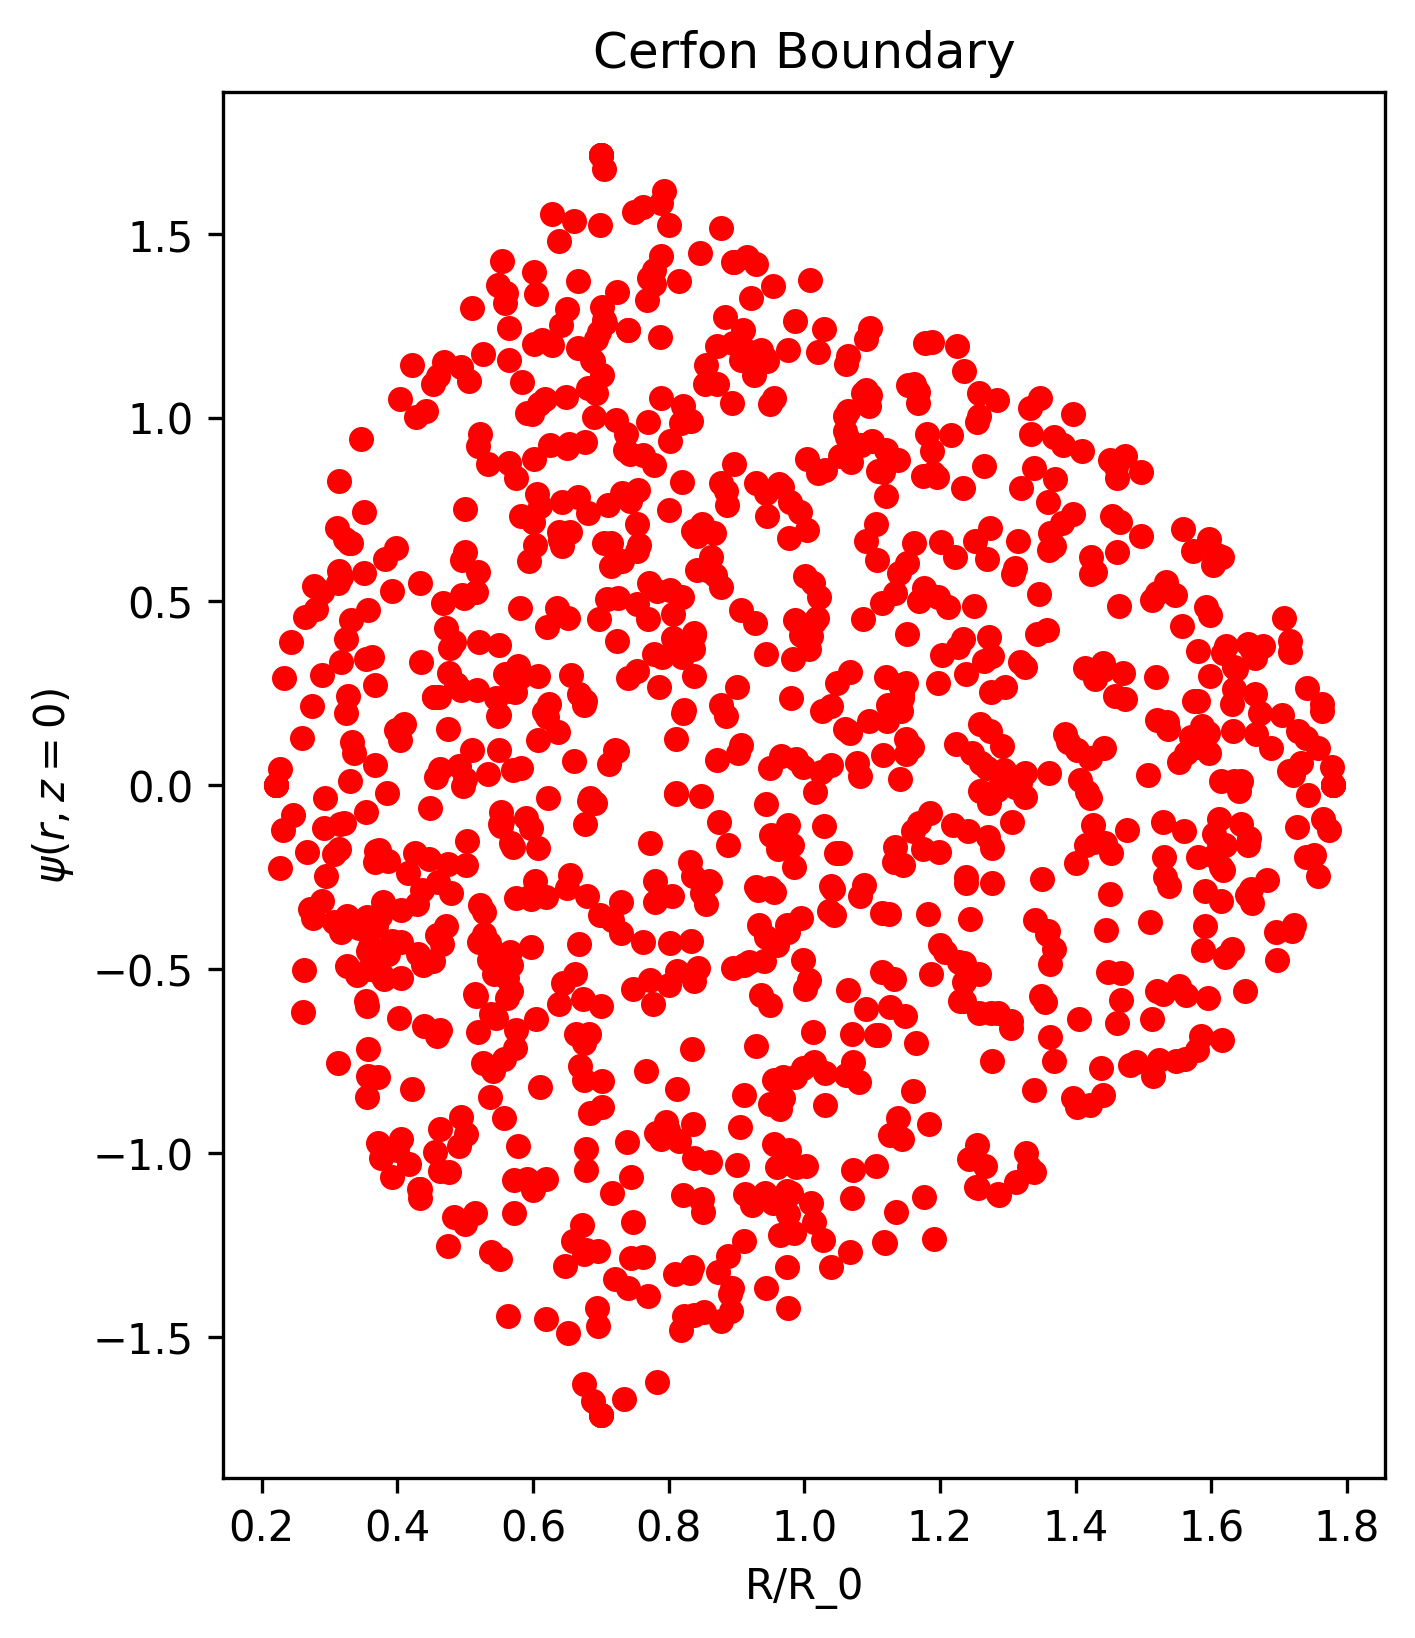

In [6]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5,6))
ax.scatter(data.train_x[:,0], data.train_x[:,1], s = 25, color='r')
# ax.scatter(spatial_domain.x_ellipse[:,0], spatial_domain.x_ellipse[:,1], s = 25, color='r')
# ax.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])
ax.set_title('Cerfon Boundary')
ax.set_xlabel(r'R/R_0')
ax.set_ylabel(r'$\psi(r,z=0)$')

### Train Model

Compiling model...
'compile' took 0.003093 s

Training model...



/Users/akaptanoglu/anaconda3/envs/deepxde_copy/lib/python3.11/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [1.83e+02, 3.24e-01, 9.21e-03, 1.56e-03, 8.28e-02, 1.70e-03, 6.24e-04, 1.91e-01, 3.72e-03, 3.63e-02]    [1.86e+02, 3.24e-01, 9.21e-03, 1.56e-03, 8.28e-02, 1.70e-03, 6.24e-04, 1.91e-01, 3.72e-03, 3.63e-02]    []  
1         [1.70e+02, 1.17e-01, 1.20e-03, 1.32e-03, 2.52e-02, 6.93e-04, 1.56e-03, 8.63e-02, 5.06e-03, 6.68e-02]    [1.72e+02, 1.17e-01, 1.20e-03, 1.32e-03, 2.52e-02, 6.93e-04, 1.56e-03, 8.63e-02, 5.06e-03, 6.68e-02]    []  
2         [1.58e+02, 6.89e-02, 2.74e-04, 1.15e-03, 2.60e-03, 1.41e-04, 2.85e-03, 2.78e-02, 6.38e-03, 1.06e-01]    [1.60e+02, 6.89e-02, 2.74e-04, 1.15e-03, 2.60e-03, 1.41e-04, 2.85e-03, 2.78e-02, 6.38e-03, 1.06e-01]    []  
3         [1.48e+02, 1.23e-01, 3.62e-03, 1.02e-03, 1.85e-03, 5.03e-06, 4.59e-03, 2.55e-03, 7.85e-03, 

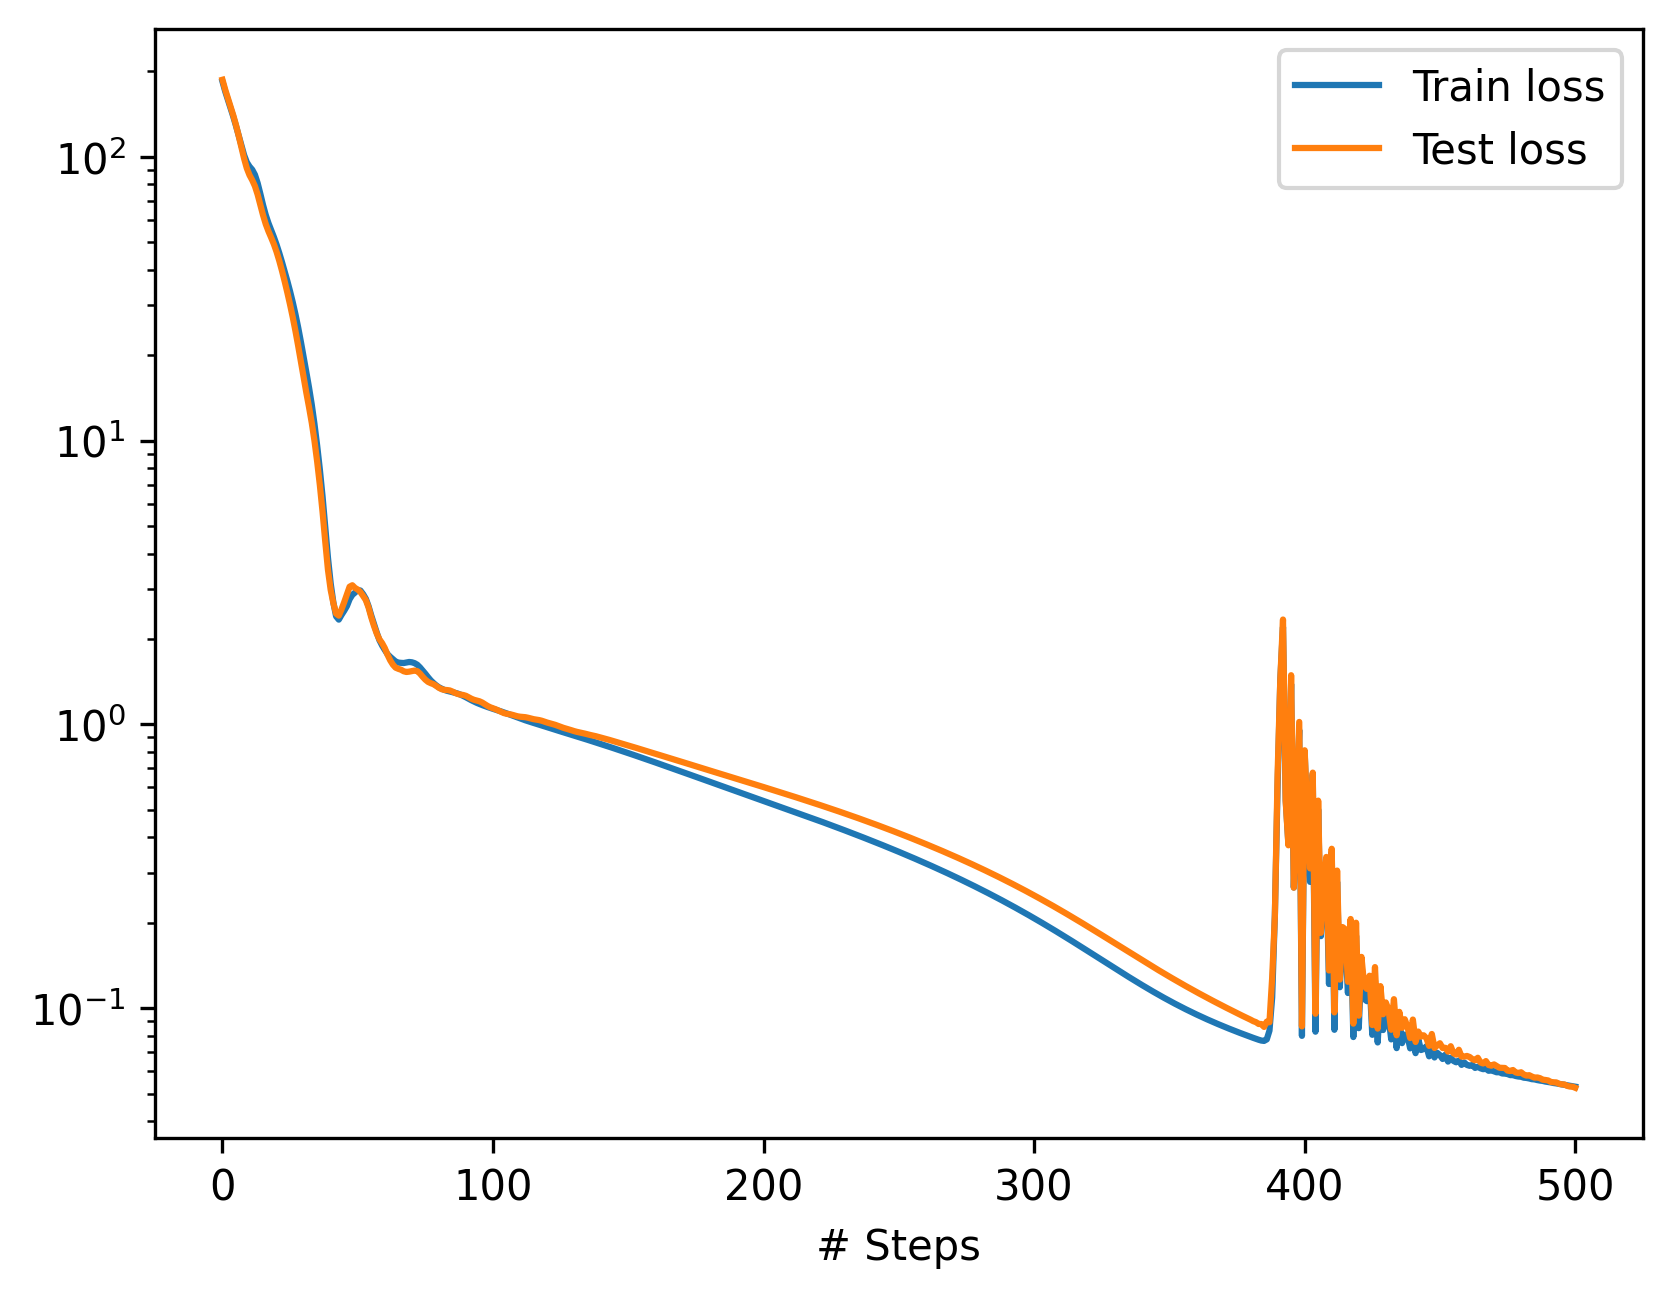

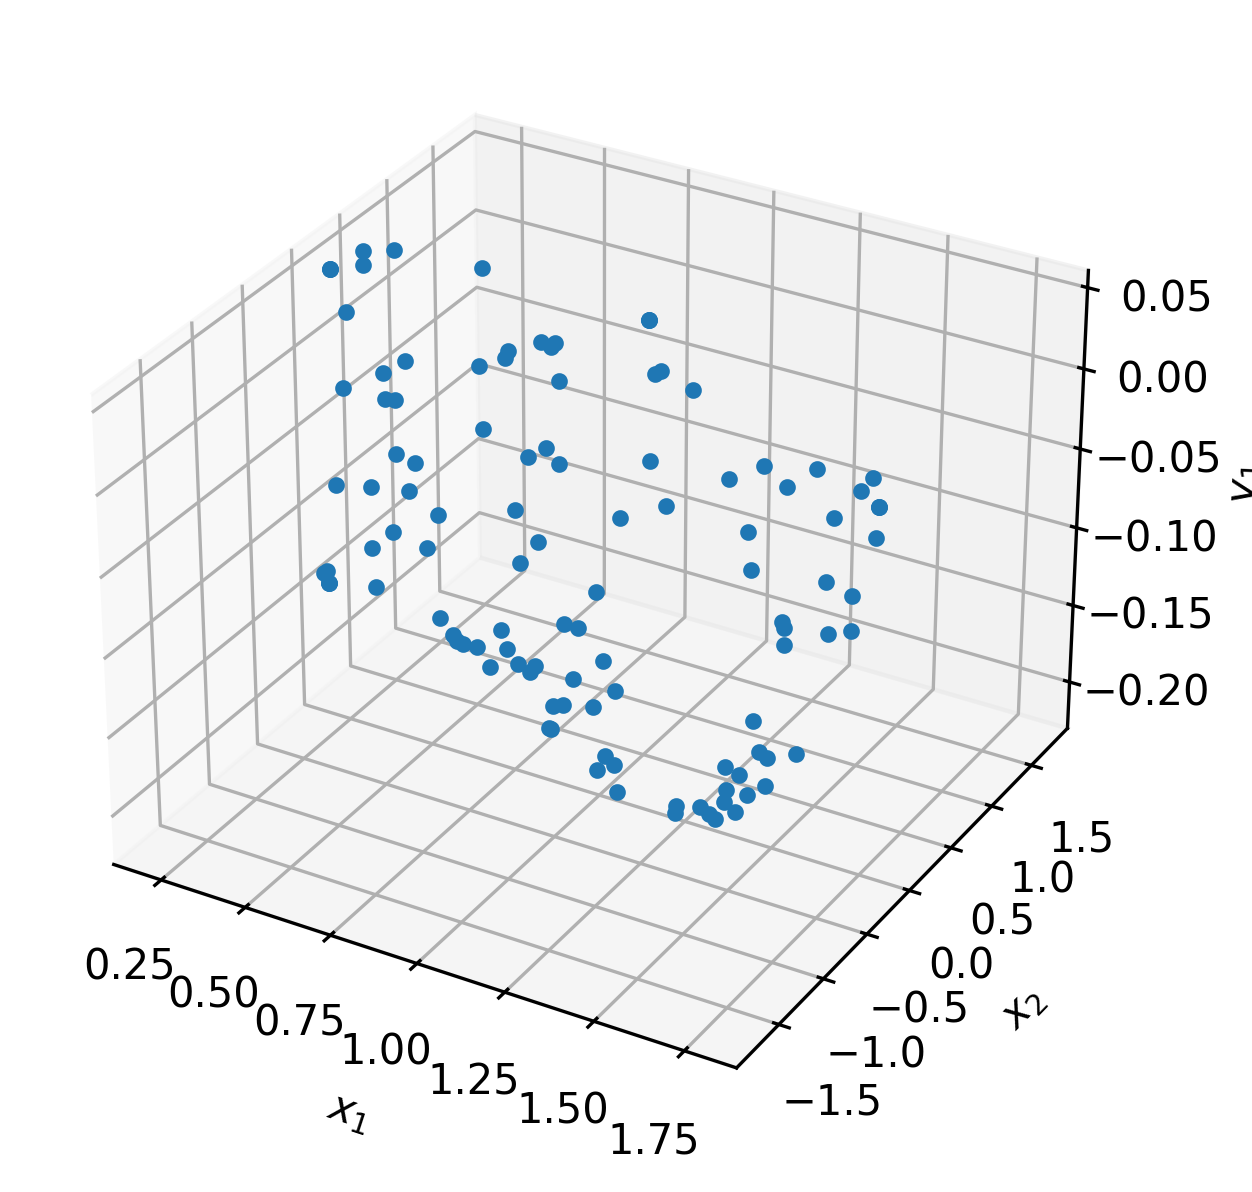

Accuracy
Mean residual: 0.074566749584131


146       [5.14e-01, 5.81e-03, 2.09e-02, 5.69e-04, 2.50e-03, 2.50e-02, 5.34e-04, 4.78e-04, 2.15e-05, 6.92e-02]    [4.52e-01, 5.81e-03, 2.09e-02, 5.69e-04, 2.50e-03, 2.50e-02, 5.34e-04, 4.78e-04, 2.15e-05, 6.92e-02]    []  
147       [5.11e-01, 5.73e-03, 2.03e-02, 5.90e-04, 2.41e-03, 2.44e-02, 5.44e-04, 4.42e-04, 1.61e-05, 6.85e-02]    [4.49e-01, 5.73e-03, 2.03e-02, 5.90e-04, 2.41e-03, 2.44e-02, 5.44e-04, 4.42e-04, 1.61e-05, 6.85e-02]    []  
148       [5.08e-01, 5.66e-03, 1.98e-02, 6.12e-04, 2.33e-03, 2.39e-02, 5.54e-04, 4.07e-04, 1.13e-05, 6.78e-02]    [4.47e-01, 5.66e-03, 1.98e-02, 6.12e-04, 2.33e-03, 2.39e-02, 5.54e-04, 4.07e-04, 1.13e-05, 6.78e-02]    []  
149       [5.05e-01, 5.60e-03, 1.93e-02, 6.32e-04, 2.27e-03, 2.34e-02, 5.64e-04, 3.77e-04, 7.18e-06, 6.71e-02]    [4.44e-01, 5.60e-03, 1.93e-02, 6.32e-04, 2.27e-03, 2.34e-02, 5.64e-04, 3.77e-04, 7.18e-06, 6.71e-02]    []  
150       [5.02e-01, 5.58e-03, 1.88e-02, 6.52e-04, 2.24e-03, 2.30e-02, 5.73e-04, 3.53e-04, 3.86e-06, 6.64e-0

183       [4.01e-01, 7.17e-03, 9.57e-03, 1.19e-03, 1.65e-03, 1.23e-02, 7.72e-04, 1.77e-04, 2.52e-04, 5.10e-02]    [3.44e-01, 7.17e-03, 9.57e-03, 1.19e-03, 1.65e-03, 1.23e-02, 7.72e-04, 1.77e-04, 2.52e-04, 5.10e-02]    []  
184       [3.98e-01, 7.23e-03, 9.39e-03, 1.20e-03, 1.62e-03, 1.21e-02, 7.72e-04, 1.67e-04, 2.64e-04, 5.06e-02]    [3.41e-01, 7.23e-03, 9.39e-03, 1.20e-03, 1.62e-03, 1.21e-02, 7.72e-04, 1.67e-04, 2.64e-04, 5.06e-02]    []  
185       [3.96e-01, 7.29e-03, 9.21e-03, 1.22e-03, 1.59e-03, 1.19e-02, 7.71e-04, 1.58e-04, 2.76e-04, 5.03e-02]    [3.39e-01, 7.29e-03, 9.21e-03, 1.22e-03, 1.59e-03, 1.19e-02, 7.71e-04, 1.58e-04, 2.76e-04, 5.03e-02]    []  
186       [3.93e-01, 7.35e-03, 9.04e-03, 1.23e-03, 1.56e-03, 1.17e-02, 7.70e-04, 1.48e-04, 2.87e-04, 4.99e-02]    [3.36e-01, 7.35e-03, 9.04e-03, 1.23e-03, 1.56e-03, 1.17e-02, 7.70e-04, 1.48e-04, 2.87e-04, 4.99e-02]    []  
187       [3.90e-01, 7.40e-03, 8.88e-03, 1.24e-03, 1.53e-03, 1.15e-02, 7.68e-04, 1.39e-04, 2.99e-04, 4.96e-0

220       [3.05e-01, 8.63e-03, 5.51e-03, 1.39e-03, 6.65e-04, 7.66e-03, 5.69e-04, 1.78e-05, 5.84e-04, 4.12e-02]    [2.54e-01, 8.63e-03, 5.51e-03, 1.39e-03, 6.65e-04, 7.66e-03, 5.69e-04, 1.78e-05, 5.84e-04, 4.12e-02]    []  
221       [3.03e-01, 8.65e-03, 5.45e-03, 1.39e-03, 6.45e-04, 7.60e-03, 5.61e-04, 2.24e-05, 5.90e-04, 4.10e-02]    [2.51e-01, 8.65e-03, 5.45e-03, 1.39e-03, 6.45e-04, 7.60e-03, 5.61e-04, 2.24e-05, 5.90e-04, 4.10e-02]    []  
222       [3.01e-01, 8.67e-03, 5.40e-03, 1.39e-03, 6.25e-04, 7.53e-03, 5.53e-04, 2.76e-05, 5.96e-04, 4.08e-02]    [2.49e-01, 8.67e-03, 5.40e-03, 1.39e-03, 6.25e-04, 7.53e-03, 5.53e-04, 2.76e-05, 5.96e-04, 4.08e-02]    []  
223       [2.98e-01, 8.68e-03, 5.34e-03, 1.38e-03, 6.04e-04, 7.47e-03, 5.45e-04, 3.32e-05, 6.02e-04, 4.06e-02]    [2.47e-01, 8.68e-03, 5.34e-03, 1.38e-03, 6.04e-04, 7.47e-03, 5.45e-04, 3.32e-05, 6.02e-04, 4.06e-02]    []  
224       [2.96e-01, 8.70e-03, 5.29e-03, 1.38e-03, 5.84e-04, 7.41e-03, 5.37e-04, 3.94e-05, 6.08e-04, 4.04e-0

257       [2.28e-01, 8.97e-03, 4.00e-03, 1.22e-03, 1.38e-04, 5.79e-03, 3.15e-04, 4.41e-04, 7.75e-04, 3.51e-02]    [1.83e-01, 8.97e-03, 4.00e-03, 1.22e-03, 1.38e-04, 5.79e-03, 3.15e-04, 4.41e-04, 7.75e-04, 3.51e-02]    []  
258       [2.26e-01, 8.97e-03, 3.97e-03, 1.22e-03, 1.31e-04, 5.75e-03, 3.10e-04, 4.56e-04, 7.81e-04, 3.50e-02]    [1.82e-01, 8.97e-03, 3.97e-03, 1.22e-03, 1.31e-04, 5.75e-03, 3.10e-04, 4.56e-04, 7.81e-04, 3.50e-02]    []  
259       [2.24e-01, 8.98e-03, 3.94e-03, 1.21e-03, 1.24e-04, 5.71e-03, 3.05e-04, 4.71e-04, 7.86e-04, 3.48e-02]    [1.80e-01, 8.98e-03, 3.94e-03, 1.21e-03, 1.24e-04, 5.71e-03, 3.05e-04, 4.71e-04, 7.86e-04, 3.48e-02]    []  
260       [2.23e-01, 8.98e-03, 3.90e-03, 1.21e-03, 1.17e-04, 5.66e-03, 3.00e-04, 4.87e-04, 7.91e-04, 3.47e-02]    [1.79e-01, 8.98e-03, 3.90e-03, 1.21e-03, 1.17e-04, 5.66e-03, 3.00e-04, 4.87e-04, 7.91e-04, 3.47e-02]    []  
261       [2.21e-01, 8.99e-03, 3.87e-03, 1.20e-03, 1.11e-04, 5.62e-03, 2.95e-04, 5.02e-04, 7.96e-04, 3.46e-0

294       [1.68e-01, 9.12e-03, 2.82e-03, 1.02e-03, 4.91e-06, 4.32e-03, 1.62e-04, 9.75e-04, 9.34e-04, 3.00e-02]    [1.31e-01, 9.12e-03, 2.82e-03, 1.02e-03, 4.91e-06, 4.32e-03, 1.62e-04, 9.75e-04, 9.34e-04, 3.00e-02]    []  
295       [1.67e-01, 9.13e-03, 2.79e-03, 1.01e-03, 4.04e-06, 4.28e-03, 1.59e-04, 9.88e-04, 9.37e-04, 2.99e-02]    [1.30e-01, 9.13e-03, 2.79e-03, 1.01e-03, 4.04e-06, 4.28e-03, 1.59e-04, 9.88e-04, 9.37e-04, 2.99e-02]    []  
296       [1.66e-01, 9.13e-03, 2.76e-03, 1.01e-03, 3.27e-06, 4.25e-03, 1.55e-04, 1.00e-03, 9.39e-04, 2.98e-02]    [1.29e-01, 9.13e-03, 2.76e-03, 1.01e-03, 3.27e-06, 4.25e-03, 1.55e-04, 1.00e-03, 9.39e-04, 2.98e-02]    []  
297       [1.64e-01, 9.13e-03, 2.73e-03, 1.00e-03, 2.58e-06, 4.21e-03, 1.52e-04, 1.01e-03, 9.41e-04, 2.96e-02]    [1.28e-01, 9.13e-03, 2.73e-03, 1.00e-03, 2.58e-06, 4.21e-03, 1.52e-04, 1.01e-03, 9.41e-04, 2.96e-02]    []  
298       [1.63e-01, 9.13e-03, 2.70e-03, 9.96e-04, 1.99e-06, 4.18e-03, 1.49e-04, 1.03e-03, 9.43e-04, 2.95e-0

331       [1.23e-01, 9.18e-03, 1.82e-03, 8.23e-04, 1.53e-05, 3.28e-03, 6.09e-05, 1.35e-03, 9.23e-04, 2.51e-02]    [9.26e-02, 9.18e-03, 1.82e-03, 8.23e-04, 1.53e-05, 3.28e-03, 6.09e-05, 1.35e-03, 9.23e-04, 2.51e-02]    []  
332       [1.22e-01, 9.18e-03, 1.79e-03, 8.18e-04, 1.63e-05, 3.25e-03, 5.88e-05, 1.35e-03, 9.20e-04, 2.50e-02]    [9.17e-02, 9.18e-03, 1.79e-03, 8.18e-04, 1.63e-05, 3.25e-03, 5.88e-05, 1.35e-03, 9.20e-04, 2.50e-02]    []  
333       [1.21e-01, 9.18e-03, 1.77e-03, 8.13e-04, 1.73e-05, 3.23e-03, 5.68e-05, 1.36e-03, 9.16e-04, 2.49e-02]    [9.09e-02, 9.18e-03, 1.77e-03, 8.13e-04, 1.73e-05, 3.23e-03, 5.68e-05, 1.36e-03, 9.16e-04, 2.49e-02]    []  
334       [1.20e-01, 9.18e-03, 1.74e-03, 8.08e-04, 1.84e-05, 3.21e-03, 5.47e-05, 1.37e-03, 9.13e-04, 2.47e-02]    [9.00e-02, 9.18e-03, 1.74e-03, 8.08e-04, 1.84e-05, 3.21e-03, 5.47e-05, 1.37e-03, 9.13e-04, 2.47e-02]    []  
335       [1.19e-01, 9.18e-03, 1.72e-03, 8.03e-04, 1.94e-05, 3.19e-03, 5.28e-05, 1.37e-03, 9.09e-04, 2.46e-0

368       [9.29e-02, 8.89e-03, 1.53e-03, 6.53e-04, 8.84e-05, 2.53e-03, 4.93e-07, 1.92e-03, 6.55e-04, 2.07e-02]    [6.72e-02, 8.89e-03, 1.53e-03, 6.53e-04, 8.84e-05, 2.53e-03, 4.93e-07, 1.92e-03, 6.55e-04, 2.07e-02]    []  
369       [1.90e-01, 9.27e-03, 2.20e-03, 5.91e-04, 8.34e-06, 4.38e-03, 6.44e-06, 1.74e-03, 7.88e-04, 2.31e-02]    [1.84e-01, 9.27e-03, 2.20e-03, 5.91e-04, 8.34e-06, 4.38e-03, 6.44e-06, 1.74e-03, 7.88e-04, 2.31e-02]    []  
370       [2.05e-01, 9.13e-03, 9.09e-04, 7.43e-04, 2.59e-04, 1.33e-03, 9.07e-07, 2.59e-03, 5.99e-04, 1.75e-02]    [1.53e-01, 9.13e-03, 9.09e-04, 7.43e-04, 2.59e-04, 1.33e-03, 9.07e-07, 2.59e-03, 5.99e-04, 1.75e-02]    []  
371       [9.19e-02, 9.09e-03, 1.38e-03, 6.44e-04, 1.36e-04, 3.09e-03, 2.43e-06, 2.34e-03, 7.16e-04, 2.04e-02]    [7.13e-02, 9.09e-03, 1.38e-03, 6.44e-04, 1.36e-04, 3.09e-03, 2.43e-06, 2.34e-03, 7.16e-04, 2.04e-02]    []  
372       [1.49e-01, 9.22e-03, 1.68e-03, 5.90e-04, 7.82e-05, 4.41e-03, 9.04e-06, 2.16e-03, 7.87e-04, 2.20e-0

405       [7.58e-02, 9.38e-03, 5.61e-04, 6.19e-04, 9.66e-05, 1.89e-03, 2.14e-07, 1.51e-03, 4.98e-04, 1.68e-02]    [5.09e-02, 9.38e-03, 5.61e-04, 6.19e-04, 9.66e-05, 1.89e-03, 2.14e-07, 1.51e-03, 4.98e-04, 1.68e-02]    []  
406       [7.10e-02, 9.42e-03, 6.46e-04, 5.90e-04, 6.10e-05, 2.30e-03, 2.68e-09, 1.42e-03, 5.21e-04, 1.74e-02]    [5.23e-02, 9.42e-03, 6.46e-04, 5.90e-04, 6.10e-05, 2.30e-03, 2.68e-09, 1.42e-03, 5.21e-04, 1.74e-02]    []  
407       [7.02e-02, 9.43e-03, 6.37e-04, 5.88e-04, 5.59e-05, 2.26e-03, 8.75e-09, 1.41e-03, 5.17e-04, 1.73e-02]    [5.12e-02, 9.43e-03, 6.37e-04, 5.88e-04, 5.59e-05, 2.26e-03, 8.75e-09, 1.41e-03, 5.17e-04, 1.73e-02]    []  
408       [7.29e-02, 9.41e-03, 5.60e-04, 6.02e-04, 7.34e-05, 1.91e-03, 4.68e-07, 1.46e-03, 4.92e-04, 1.66e-02]    [4.91e-02, 9.41e-03, 5.60e-04, 6.02e-04, 7.34e-05, 1.91e-03, 4.68e-07, 1.46e-03, 4.92e-04, 1.66e-02]    []  
409       [7.02e-02, 9.45e-03, 6.43e-04, 5.74e-04, 5.43e-05, 2.32e-03, 2.53e-08, 1.39e-03, 5.07e-04, 1.72e-0

442       [5.25e-02, 9.40e-03, 3.29e-04, 4.39e-04, 9.06e-05, 1.65e-03, 1.26e-05, 1.37e-03, 2.76e-04, 1.39e-02]    [3.63e-02, 9.40e-03, 3.29e-04, 4.39e-04, 9.06e-05, 1.65e-03, 1.26e-05, 1.37e-03, 2.76e-04, 1.39e-02]    []  
443       [5.21e-02, 9.40e-03, 3.20e-04, 4.36e-04, 9.12e-05, 1.60e-03, 1.36e-05, 1.36e-03, 2.68e-04, 1.38e-02]    [3.57e-02, 9.40e-03, 3.20e-04, 4.36e-04, 9.12e-05, 1.60e-03, 1.36e-05, 1.36e-03, 2.68e-04, 1.38e-02]    []  
444       [5.15e-02, 9.41e-03, 3.25e-04, 4.29e-04, 8.60e-05, 1.65e-03, 1.34e-05, 1.34e-03, 2.65e-04, 1.38e-02]    [3.61e-02, 9.41e-03, 3.25e-04, 4.29e-04, 8.60e-05, 1.65e-03, 1.34e-05, 1.34e-03, 2.65e-04, 1.38e-02]    []  
445       [5.12e-02, 9.40e-03, 3.09e-04, 4.29e-04, 8.96e-05, 1.57e-03, 1.50e-05, 1.34e-03, 2.56e-04, 1.36e-02]    [3.50e-02, 9.40e-03, 3.09e-04, 4.29e-04, 8.96e-05, 1.57e-03, 1.50e-05, 1.34e-03, 2.56e-04, 1.36e-02]    []  
446       [5.06e-02, 9.41e-03, 3.08e-04, 4.22e-04, 8.72e-05, 1.60e-03, 1.49e-05, 1.33e-03, 2.53e-04, 1.36e-0

479       [3.69e-02, 9.42e-03, 1.10e-04, 3.12e-04, 8.29e-05, 1.17e-03, 3.89e-05, 1.18e-03, 1.03e-04, 1.11e-02]    [2.49e-02, 9.42e-03, 1.10e-04, 3.12e-04, 8.29e-05, 1.17e-03, 3.89e-05, 1.18e-03, 1.03e-04, 1.11e-02]    []  
480       [3.65e-02, 9.42e-03, 1.07e-04, 3.08e-04, 8.23e-05, 1.17e-03, 3.96e-05, 1.18e-03, 9.93e-05, 1.10e-02]    [2.47e-02, 9.42e-03, 1.07e-04, 3.08e-04, 8.23e-05, 1.17e-03, 3.96e-05, 1.18e-03, 9.93e-05, 1.10e-02]    []  
481       [3.62e-02, 9.42e-03, 1.02e-04, 3.06e-04, 8.25e-05, 1.15e-03, 4.06e-05, 1.17e-03, 9.54e-05, 1.09e-02]    [2.44e-02, 9.42e-03, 1.02e-04, 3.06e-04, 8.25e-05, 1.15e-03, 4.06e-05, 1.17e-03, 9.54e-05, 1.09e-02]    []  
482       [3.58e-02, 9.42e-03, 9.82e-05, 3.02e-04, 8.19e-05, 1.15e-03, 4.11e-05, 1.16e-03, 9.22e-05, 1.09e-02]    [2.42e-02, 9.42e-03, 9.82e-05, 3.02e-04, 8.19e-05, 1.15e-03, 4.11e-05, 1.16e-03, 9.22e-05, 1.09e-02]    []  
483       [3.54e-02, 9.42e-03, 9.32e-05, 3.00e-04, 8.23e-05, 1.12e-03, 4.23e-05, 1.16e-03, 8.83e-05, 1.08e-0

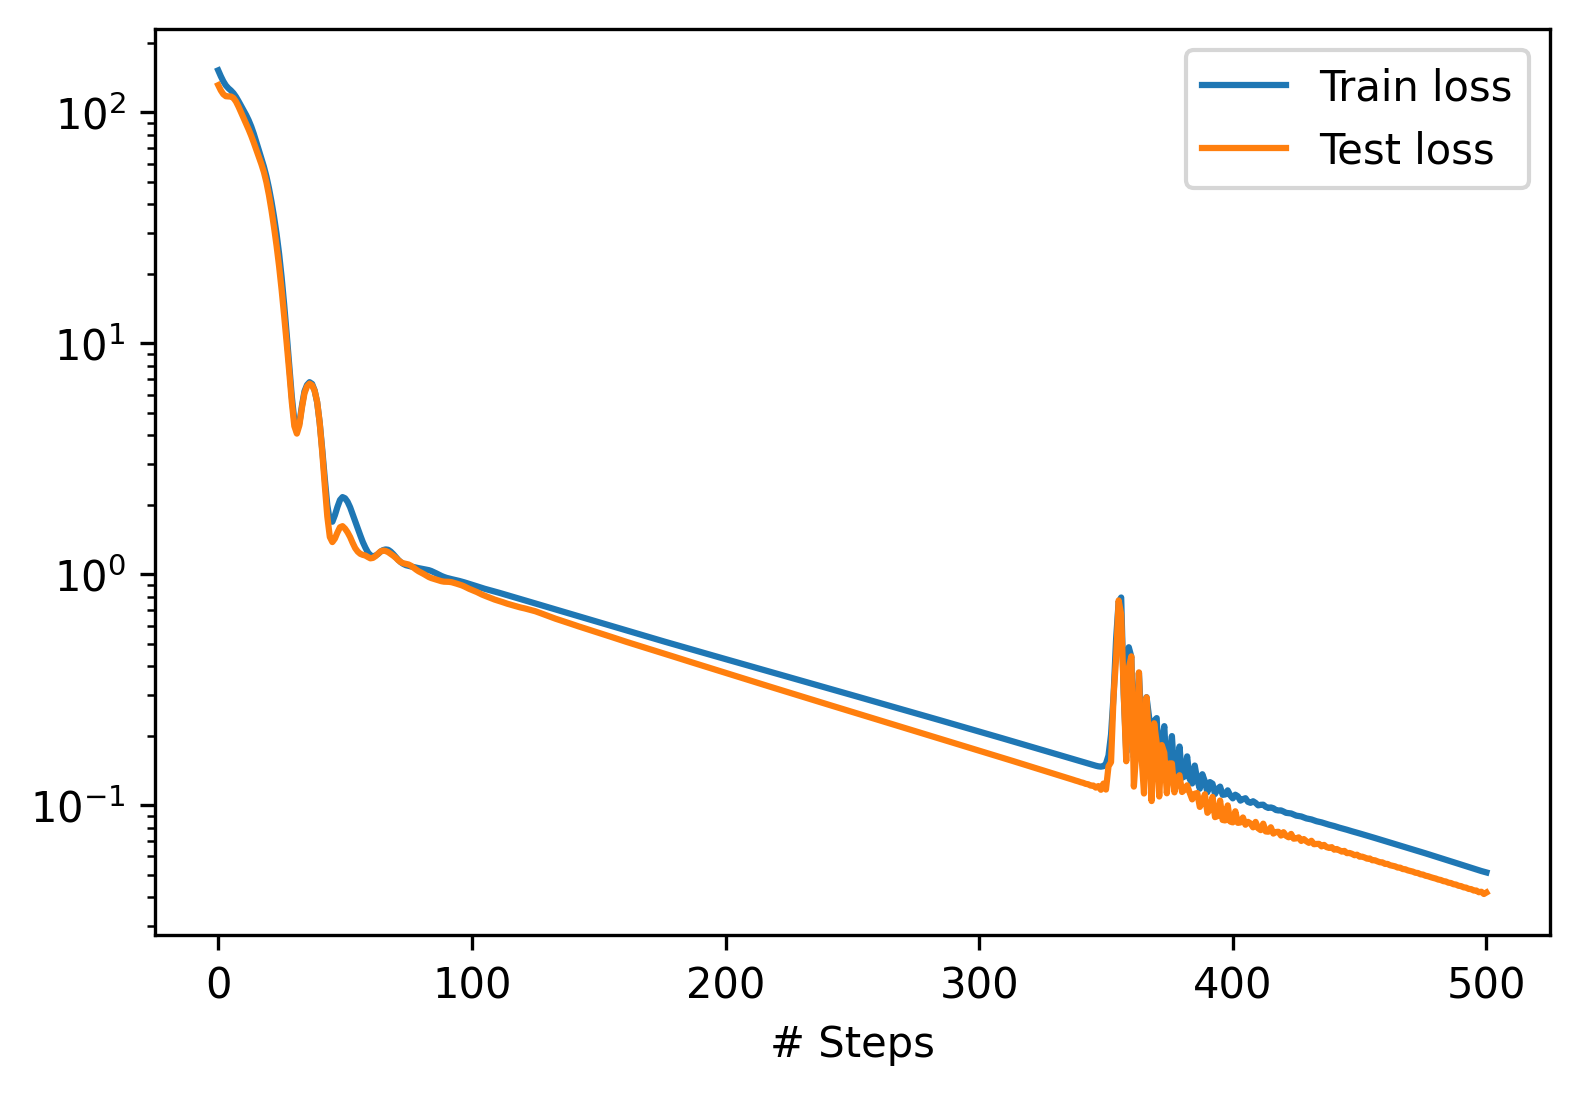

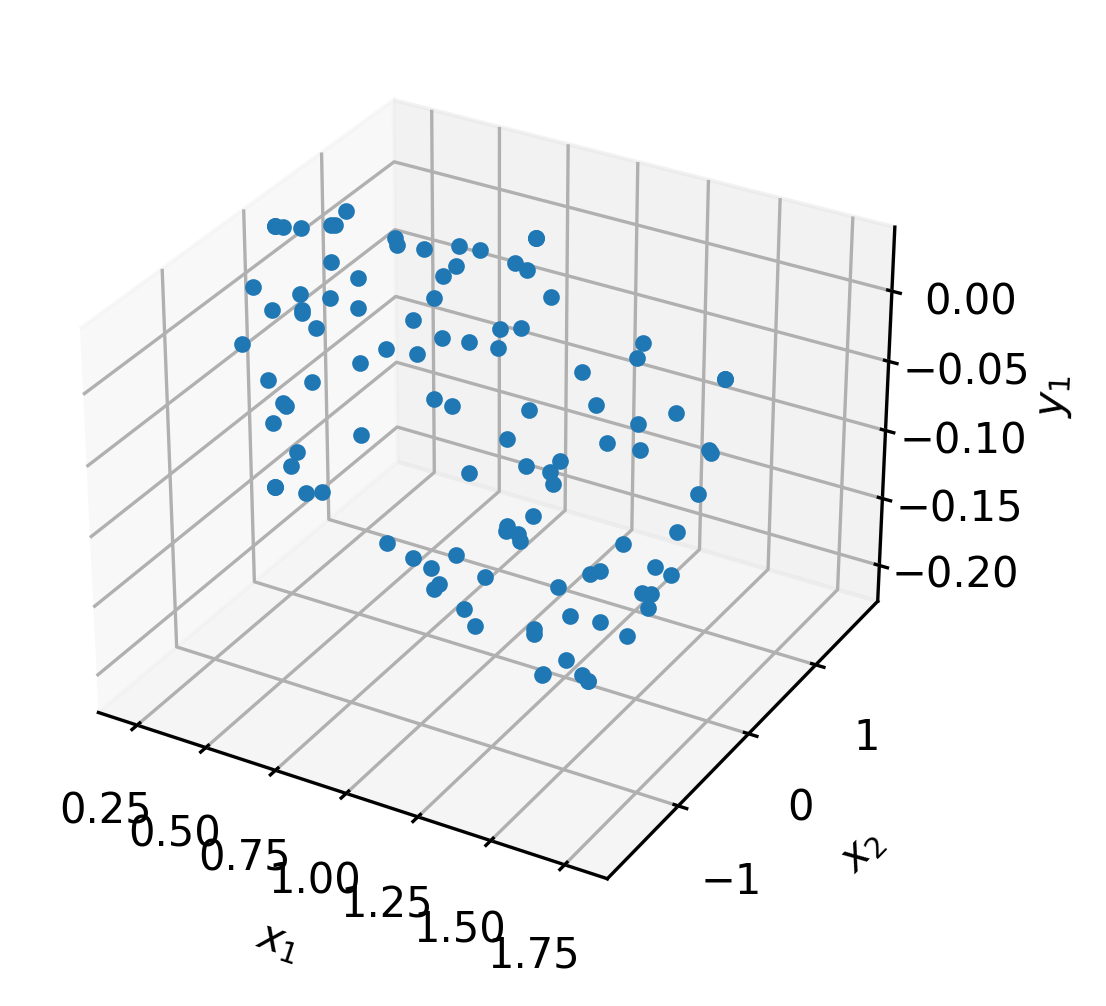

Accuracy
Mean residual: 0.058506876


In [7]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10132022"
CONFIG = "DoubleNullITER"
LR = 8e-3
DEPTH = 3
BREADTH = 20
run = "01_500Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([2] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[100,10,1,1,
                    5,5,1,5,
                    1,5]  )


  loss_history, train_state = model.train(epochs=500, display_every = 1)
  dde.saveplot(loss_history, train_state, issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

# make mesh
nx = 201
ny = 201
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

### Plotting

#### Before BFGS

(501, 501)
Average normalized percent error =  8.345081372450071
Max normalized percent error =  22.35554007745154


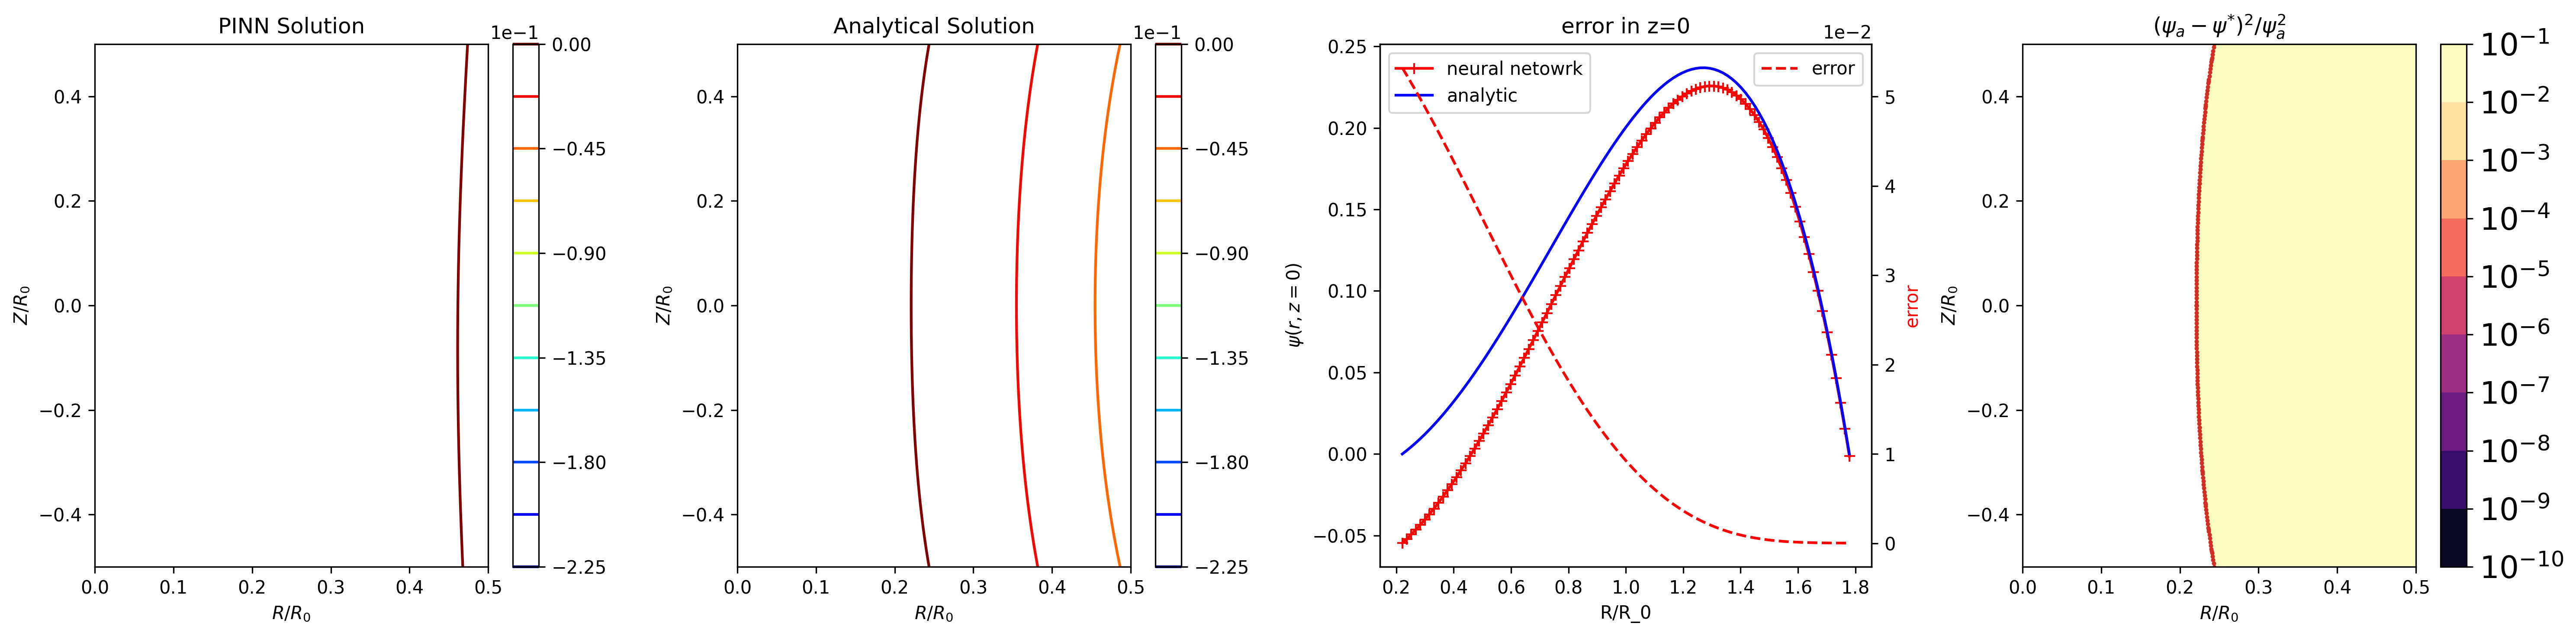

In [12]:
# Evaluation
from utils.utils import evaluate,evaluate_eq, relative_error_plot
from matplotlib.pyplot import colorbar, Normalize, show, subplots
from matplotlib.cm import ScalarMappable, jet, inferno
X_test = spatial_domain.random_points(333)

x,y,psi_pred,psi_true,error=evaluate(NSTX,model)
x_eq, psi_true_eq, psi_pred_eq, e_eq= evaluate_eq(NSTX,model)

# Plotting Setup
plt.rcParams['figure.dpi'] = 300
print(psi_pred.shape)
fig,axs=plt.subplots(1,4,figsize=(20,5))
ax1,ax2,ax3,ax4=axs[0],axs[1],axs[2],axs[3]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# ColorMap setting
norm = Normalize(vmin=np.min(psi_pred), vmax=0)
cmap = jet

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred,norm=norm,cmap=cmap,levels=D)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true,norm=norm,cmap=cmap,levels=D)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

# Plot 3 - Equatorial Error
twin3 = ax3.twinx()
ax3.plot(x_eq, -psi_pred_eq,marker="+",color="red",label="neural netowrk")
ax3.plot(x_eq, -psi_true_eq,color="blue",label="analytic")
twin3.plot(x_eq, e_eq, color='red',linestyle='--',label="error")
twin3.yaxis.get_major_formatter().set_scientific(True)
ax3.set_title('error in z=0')
ax3.set_xlabel('R/R_0')
ax3.set_ylabel(r'$\psi(r,z=0)$')
ax3.legend(loc='upper left')
twin3.legend(loc='upper right')
twin3.set_ylabel('error', color='red')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Plot 4 - Relative Error
fig, ax4 = relative_error_plot(fig,ax4,x,y,error,model,NSTX,v=v,X_test=X_test)
ax4.scatter(v[:,0],v[:,1], s = 2,c="#D12F24")
# ax4.set_title(r'$($\psi$_{n}-u^{*})^2/u_{a}^2$')
ax4.set_title(r'($\psi_{a}-\psi^{*})^2/\psi_{a}^2$')
ax4.set_xlabel(r'$R/R_{0}$')
ax4.set_ylabel(r'$Z/R_{0}$')
ax4.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

fig.tight_layout()
plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_before_BFGS.jpg')




#### After BFGS

Compiling model...
'compile' took 0.002977 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
500       [3.49e-03, 1.12e-02, 1.28e-03, 4.18e-04, 2.02e-05, 4.45e-03, 7.37e-06, 9.94e-05, 2.49e-05, 5.71e-03]    [3.45e-03, 1.12e-02, 1.28e-03, 4.18e-04, 2.02e-05, 4.45e-03, 7.37e-06, 9.94e-05, 2.49e-05, 5.71e-03]    []  


1590      [1.13e-04, 1.07e-06, 1.13e-10, 2.46e-07, 3.17e-08, 4.39e-08, 2.83e-08, 4.28e-09, 4.66e-10, 7.91e-09]    [1.13e-04, 1.07e-06, 1.13e-10, 2.46e-07, 3.17e-08, 4.39e-08, 2.83e-08, 4.28e-09, 4.66e-10, 7.91e-09]        
1600      [1.12e-04, 6.95e-07, 6.49e-09, 5.82e-08, 5.21e-09, 4.80e-08, 3.39e-09, 7.68e-10, 6.98e-09, 2.01e-09]    [1.12e-04, 6.95e-07, 6.49e-09, 5.82e-08, 5.21e-09, 4.80e-08, 3.39e-09, 7.68e-10, 6.98e-09, 2.01e-09]        
1610      [1.10e-04, 7.73e-07, 1.00e-10, 1.51e-07, 1.48e-08, 6.00e-08, 8.73e-08, 1.74e-12, 1.59e-08, 4.16e-09]    [1.10e-04, 7.73e-07, 1.00e-10, 1.51e-07, 1.48e-08, 6.00e-08, 8.73e-08, 1.74e-12, 1.59e-08, 4.16e-09]        
1620      [1.09e-04, 9.59e-07, 1.74e-10, 1.55e-07, 7.06e-10, 3.67e-08, 3.43e-08, 4.80e-09, 1.43e-09, 3.24e-09]    [1.09e-04, 9.59e-07, 1.74e-10, 1.55e-07, 7.06e-10, 3.67e-08, 3.43e-08, 4.80e-09, 1.43e-09, 3.24e-09]        
1630      [1.08e-04, 1.18e-06, 4.96e-09, 6.28e-08, 8.65e-10, 3.36e-08, 2.12e-08, 3.27e-09, 9.98e-10, 2.26e-0

1960      [3.91e-05, 5.97e-07, 6.86e-11, 3.01e-07, 1.78e-09, 7.71e-09, 1.86e-07, 1.10e-08, 2.03e-10, 1.64e-10]    [3.91e-05, 5.97e-07, 6.86e-11, 3.01e-07, 1.78e-09, 7.71e-09, 1.86e-07, 1.10e-08, 2.03e-10, 1.64e-10]        
1970      [3.91e-05, 4.41e-07, 5.69e-09, 1.48e-07, 2.29e-09, 5.68e-09, 2.57e-08, 4.17e-09, 2.01e-09, 5.74e-09]    [3.91e-05, 4.41e-07, 5.69e-09, 1.48e-07, 2.29e-09, 5.68e-09, 2.57e-08, 4.17e-09, 2.01e-09, 5.74e-09]        
1980      [3.86e-05, 3.24e-07, 6.16e-09, 5.08e-08, 3.82e-09, 8.43e-10, 6.38e-09, 6.38e-09, 6.39e-10, 2.12e-09]    [3.86e-05, 3.24e-07, 6.16e-09, 5.08e-08, 3.82e-09, 8.43e-10, 6.38e-09, 6.38e-09, 6.39e-10, 2.12e-09]        
1990      [3.73e-05, 3.16e-07, 1.63e-10, 1.70e-07, 2.57e-08, 5.46e-10, 1.11e-08, 1.79e-08, 5.38e-10, 1.59e-08]    [3.73e-05, 3.16e-07, 1.63e-10, 1.70e-07, 2.57e-08, 5.46e-10, 1.11e-08, 1.79e-08, 5.38e-10, 1.59e-08]        
2000      [3.60e-05, 4.11e-07, 1.26e-08, 1.14e-07, 1.51e-09, 4.71e-09, 1.02e-08, 6.24e-10, 4.82e-09, 5.46e-1

2330      [1.99e-05, 9.41e-08, 4.60e-09, 2.85e-08, 6.19e-10, 1.31e-09, 9.12e-09, 3.21e-10, 1.61e-10, 2.95e-09]    [1.99e-05, 9.41e-08, 4.60e-09, 2.85e-08, 6.19e-10, 1.31e-09, 9.12e-09, 3.21e-10, 1.61e-10, 2.95e-09]        
2340      [1.98e-05, 9.22e-08, 2.55e-09, 2.59e-08, 9.61e-11, 2.36e-09, 3.25e-09, 5.82e-10, 6.69e-10, 1.05e-09]    [1.98e-05, 9.22e-08, 2.55e-09, 2.59e-08, 9.61e-11, 2.36e-09, 3.25e-09, 5.82e-10, 6.69e-10, 1.05e-09]        
2350      [1.97e-05, 5.94e-08, 1.01e-09, 2.48e-08, 5.29e-10, 1.57e-09, 2.64e-09, 1.43e-10, 2.77e-10, 1.72e-09]    [1.97e-05, 5.94e-08, 1.01e-09, 2.48e-08, 5.29e-10, 1.57e-09, 2.64e-09, 1.43e-10, 2.77e-10, 1.72e-09]        
2360      [1.96e-05, 7.40e-08, 3.93e-09, 2.40e-08, 1.95e-10, 2.29e-09, 7.75e-09, 3.21e-12, 1.09e-09, 2.16e-10]    [1.96e-05, 7.40e-08, 3.93e-09, 2.40e-08, 1.95e-10, 2.29e-09, 7.75e-09, 3.21e-12, 1.09e-09, 2.16e-10]        
2370      [1.95e-05, 7.78e-08, 3.65e-09, 1.93e-08, 1.28e-10, 2.83e-09, 6.06e-09, 2.31e-11, 8.15e-10, 5.64e-1

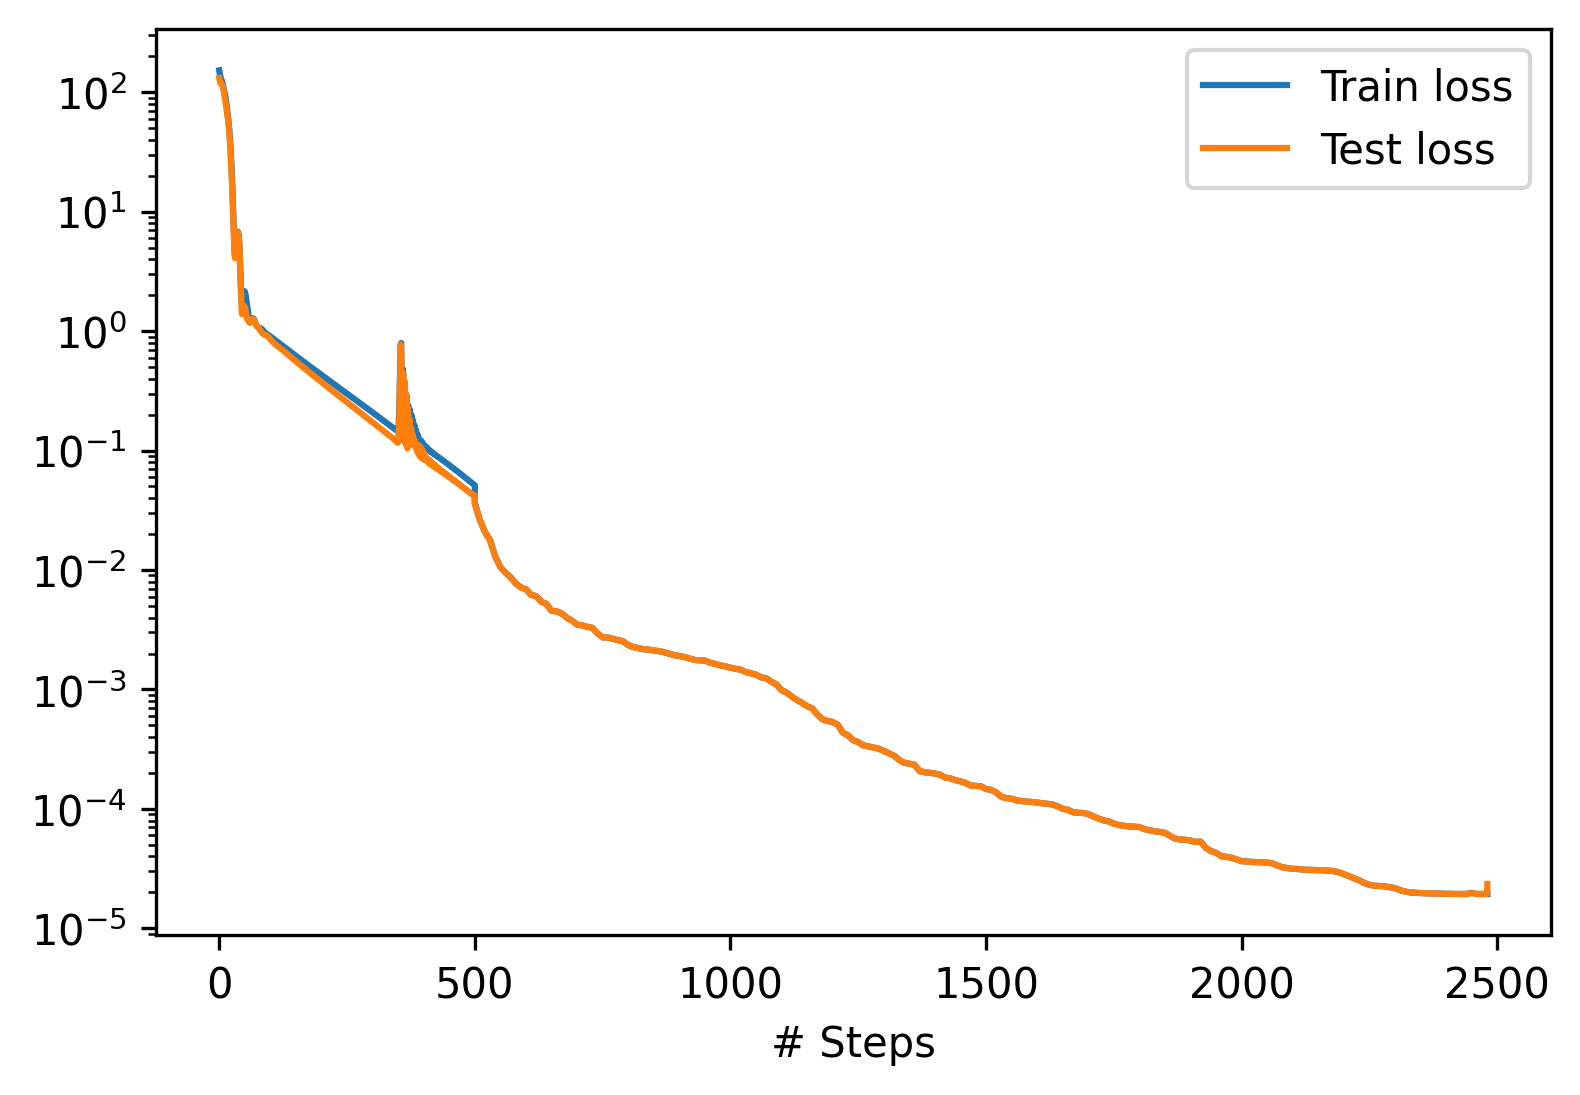

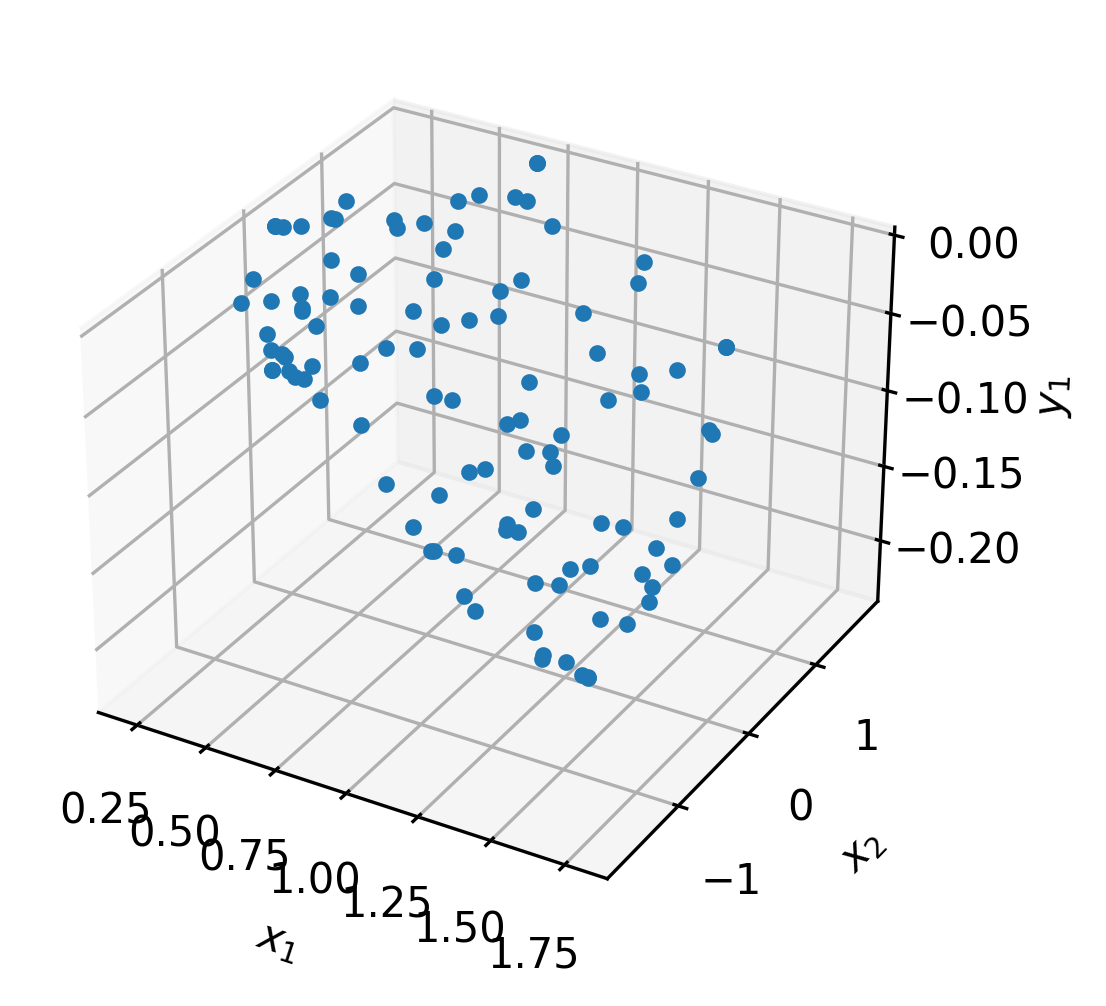

In [ ]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    # PDE Loss, fluxloss, outer_curv, inner_curv,
    # high_sep_slop_r,high_sep_slop_z, inner_slop_z, low_sep_slop_r,
    # outer_slop_z,low_sep_slop_z
    # loss_weights=[10,1,1,1,
    #             5,5,1,5,
    #             1,5]
    # loss_weights=[100,1,1,1,
    #             10,10,1,10,
    #             1,10]
    # loss_weights=[10,1,10,10,
    #                 1,1,10,1,
    #                 10,1]
    loss_weights=[10,10,1,1,
                    10,10,1,10,
                    1,10]  
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


In [ ]:
# Evaluation
from utils.utils import evaluate,evaluate_eq, relative_error_plot
from matplotlib.pyplot import colorbar, Normalize, show, subplots
from matplotlib.cm import ScalarMappable, jet, inferno

X_test = spatial_domain.random_points(333)

x,y,psi_pred,psi_true,error=evaluate(NSTX,model)
x_eq, psi_true_eq, psi_pred_eq, e_eq= evaluate_eq(NSTX,model)

# Plotting Setup
plt.rcParams['figure.dpi'] = 300
print(psi_pred.shape)
fig,axs=plt.subplots(1,4,figsize=(20,5))
ax1,ax2,ax3,ax4=axs[0],axs[1],axs[2],axs[3]
levels = np.linspace(min(psi_true.reshape(-1)),0,8)

# ColorMap setting
norm = Normalize(vmin=np.min(psi_pred), vmax=0)
cmap = jet

# Plot 1 - PINN Solution
cp = ax1.contour(x, y, psi_pred,norm=norm,cmap=cmap,levels=D)
# ax1.scatter(observe_x[:,0], observe_x[:,1], s = 2,c="black")
fig.colorbar(cp,ax=ax1).formatter.set_powerlimits((0, 0)) 
ax1.set_title('PINN Solution')
ax1.set_xlabel(r'$R/R_{0}$')
ax1.set_ylabel(r'$Z/R_{0}$')
ax1.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

# Plot 2 - Analytic Solution
cp = ax2.contour(x, y, psi_true,norm=norm,cmap=cmap,levels=D)
fig.colorbar(cp,ax=ax2).formatter.set_powerlimits((0, 0))
ax2.set_title('Analytical Solution')
ax2.set_xlabel(r'$R/R_{0}$')
ax2.set_ylabel(r'$Z/R_{0}$')
ax2.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

# Plot 3 - Equatorial Error
twin3 = ax3.twinx()
ax3.plot(x_eq, -psi_pred_eq,marker="+",color="red",label="neural netowrk")
ax3.plot(x_eq, -psi_true_eq,color="blue",label="analytic")
twin3.plot(x_eq, e_eq, color='red',linestyle='--',label="error")
twin3.yaxis.get_major_formatter().set_scientific(True)
ax3.set_title('error in z=0')
ax3.set_xlabel('R/R_0')
ax3.set_ylabel(r'$\psi(r,z=0)$')
ax3.legend(loc='upper left')
twin3.legend(loc='upper right')
twin3.set_ylabel('error', color='red')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Plot 4 - Relative Error
fig, ax4 = relative_error_plot(fig,ax4,x,y,error,model,NSTX,v=v,X_test=X_test)
ax4.scatter(v[:,0],v[:,1], s = 2,c="#D12F24")
# ax4.set_title(r'$($\psi$_{n}-u^{*})^2/u_{a}^2$')
ax4.set_title(r'($\psi_{a}-\psi^{*})^2/\psi_{a}^2$')
ax4.set_xlabel(r'$R/R_{0}$')
ax4.set_ylabel(r'$Z/R_{0}$')
ax4.axis(xmin=PLOT_PARAM["xmin"],xmax=PLOT_PARAM["xmax"],ymin=PLOT_PARAM["ymin"], ymax=PLOT_PARAM["ymax"])

fig.tight_layout()
plt.savefig(f'./cefron/{CONFIG}/runs/{RUN_NAME}/analysis_after_BFGS.jpg')
